In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 1 * 1, 1024, bias=False)
        self.dropout = nn.Dropout(0.4)
        self.fc2_mean = nn.Linear(1024, latent_dim)
        self.fc2_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        h = self.dropout(h)
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024, bias=False)
        self.fc2 = nn.Linear(1024, 512 * 1 * 1, bias=False)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # Keep bias here

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 512, 1, 1)  # Reshape tensor
        z = F.relu(self.bn1(self.deconv1(z)))
        z = F.relu(self.bn2(self.deconv2(z)))
        z = F.relu(self.bn3(self.deconv3(z)))
        z = F.relu(self.bn4(self.deconv4(z)))
        z = torch.sigmoid(self.deconv5(z))
        return z

In [4]:
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        #print(x.shape)
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        #print(z.shape)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, logvar

In [5]:
def loss_function(reconstructed_x, x, mean, logvar):
    #print(reconstructed_x.shape)
    #print(x.shape)
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Hyperparameters
input_channels = 3
latent_dim = 128
batch_size = 64
epochs = 50
learning_rate = 0.0001

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Initialize model, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
vae = VAE(input_channels, latent_dim).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=learning_rate)

In [6]:
# Hyperparameters
input_channels = 3
latent_dim = 128
batch_size = 64
epochs = 50
learning_rate = 0.0001

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer
device = torch.device('cpu')
vae = VAE(input_channels, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

100%|██████████| 170498071/170498071 [00:04<00:00, 40345854.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
def plot_reconstruction(img, recons):
    """
    Plot the original and reconstructed images during training.
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

    for j in range(5):
        # Original images - transposing to (height, width, channels)
        original_image = img[j].detach().cpu().numpy().transpose(1, 2, 0)
        axes[0][j].imshow(original_image)
        axes[0][j].axis('off')

    for j in range(5):
        # Reconstructed images - transposing to (height, width, channels)
        reconstructed_image = recons[j].detach().cpu().numpy().transpose(1, 2, 0)
        axes[1][j].imshow(reconstructed_image)
        axes[1][j].axis('off')

    plt.tight_layout(pad=0.)
    plt.show()

Epoch 1, Loss: 1992.451022578125


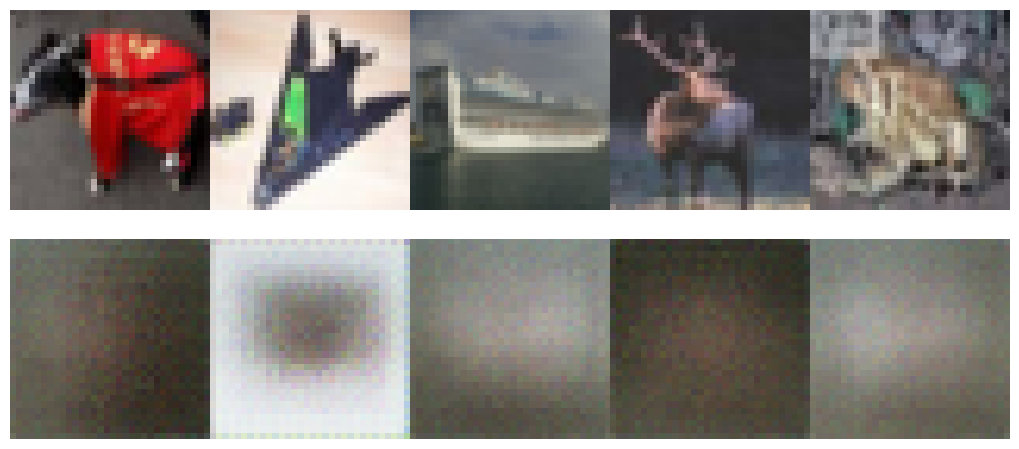

In [ ]:
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        #print(data.shape)
        reconstructed_x, mean, logvar = vae(data)
        loss = loss_function(reconstructed_x, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')
    plot_reconstruction(data, reconstructed_x)
# Save the model
torch.save(vae.state_dict(), 'vae.pth')
print("Model saved as 'vae.pth'")


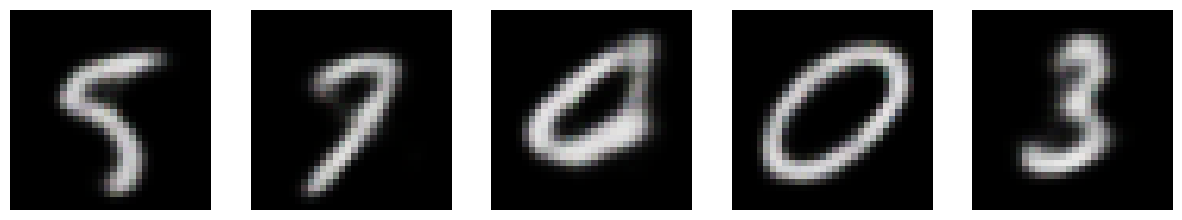

In [ ]:
# Load the model
vae.load_state_dict(torch.load('vae.pth'))
vae.eval()

# Generate random samples from a standard Gaussian distribution
num_samples = 5
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)  # Generate random latent vectors
    generated_images = vae.decoder(z)  # Decode to generate images

# Display generated images
generated_images = generated_images.cpu().numpy()
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    img = generated_images[i].transpose(1, 2, 0)  # Move the channels to the last dimension
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')

plt.show()